In [25]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

project_root = Path.cwd().parent

# One folder per Quarto page
fig_dir = project_root / "src" / "visualizations" / "automl_regression"
fig_dir.mkdir(parents=True, exist_ok=True)

preds = pd.read_csv(project_root / "data" / "processed" / "test_predictions_life_expectancy_models.csv")
metrics = pd.read_csv(project_root / "data" / "processed" / "model_comparison_metrics.csv")
preds.head()

,iso3,country_name,year,gdp_per_capita,co2_per_capita,y_actual,y_pred_linear_regression,y_pred_lgbm,y_pred_rf,y_pred_xgboost
0,MNG,Mongolia,1993,1418.065607,4.044,60.824220,62.813935,63.351031,63.207014,63.153885
1,NLD,Netherlands,2001,41297.319883,10.966,78.190244,76.077297,76.609169,77.463067,76.816400
2,GAB,Gabon,2005,7130.225058,4.252,62.978000,66.944917,67.912951,67.528558,67.883780
3,IRQ,Iraq,2015,4440.141893,3.795,69.977000,68.453716,73.703125,71.363042,72.083460
4,NAM,Namibia,2009,3989.207114,1.280,55.347000,66.208689,62.037008,63.414637,61.578580


Saved: c:\Users\jczoc\OneDrive - Bentley University\MA 705\Project\Life_Expectancy_Project\src\visualizations\automl_regression\error_distributions_by_model.png


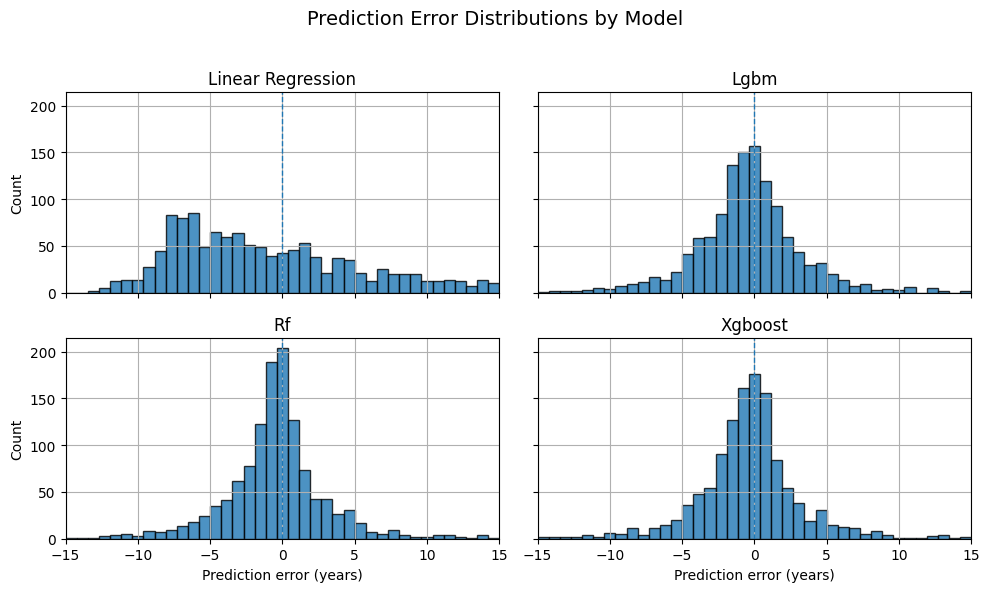

In [18]:
model_names = ["linear_regression", "lgbm", "rf", "xgboost"]

for name in model_names:
    preds[f"error_{name}"] = preds[f"y_pred_{name}"] - preds["y_actual"]

fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axes = axes.ravel()

bins = np.linspace(-15, 15, 40)

for ax, name in zip(axes, model_names):
    preds[f"error_{name}"].hist(
        ax=ax,
        bins=bins,
        alpha=0.8,
        edgecolor="black",
    )
    ax.axvline(0, linestyle="--", linewidth=1)
    ax.set_title(name.replace("_", " ").title())
    ax.set_xlim(-15, 15)

axes[2].set_xlabel("Prediction error (years)")
axes[3].set_xlabel("Prediction error (years)")
axes[0].set_ylabel("Count")
axes[2].set_ylabel("Count")

fig.suptitle("Prediction Error Distributions by Model", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])

out_path = fig_dir / "error_distributions_by_model.png"
fig.savefig(out_path, dpi=300)
print("Saved:", out_path)
plt.show()


Saved: c:\Users\jczoc\OneDrive - Bentley University\MA 705\Project\Life_Expectancy_Project\src\visualizations\automl_regression\regression_model_comparison.png


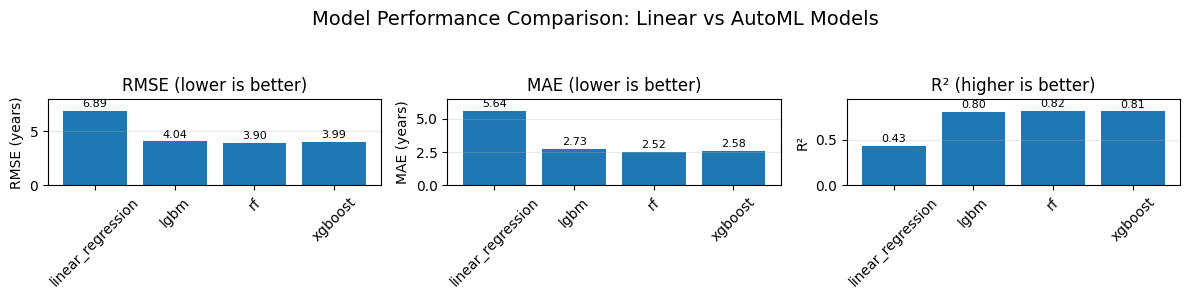

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

metrics_to_plot = ["rmse", "mae", "r2"]
titles = [
    "RMSE (lower is better)",
    "MAE (lower is better)",
    "R² (higher is better)",
]
ylabels = ["RMSE (years)", "MAE (years)", "R²"]
formats = ["{:.2f}", "{:.2f}", "{:.2f}"]  # label formatting

for ax, metric, title, ylabel, fmt in zip(axes, metrics_to_plot, titles, ylabels, formats):
    values = metrics[metric].values
    bars = ax.bar(metrics["model"], values)

    # Give some headroom above the tallest bar
    ymax = values.max() * 1.15
    ax.set_ylim(0, ymax)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis="x", rotation=45)
    ax.grid(axis="y", alpha=0.3)

    # Add labels just above the bar top
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + ymax * 0.02,  # small offset upwards
            fmt.format(value),
            ha="center",
            va="bottom",
            fontsize=8,
        )

fig.suptitle("Model Performance Comparison: Linear vs AutoML Models", fontsize=14)

# Leave room for the suptitle but still pack things nicely
plt.tight_layout(rect=[0, 0, 1, 0.92])

out_path = fig_dir / "regression_model_comparison.png"
fig.savefig(out_path, dpi=300)
print("Saved:", out_path)
plt.show()


Saved: c:\Users\jczoc\OneDrive - Bentley University\MA 705\Project\Life_Expectancy_Project\src\visualizations\automl_regression\united_states_actual_vs_pred_rf.png


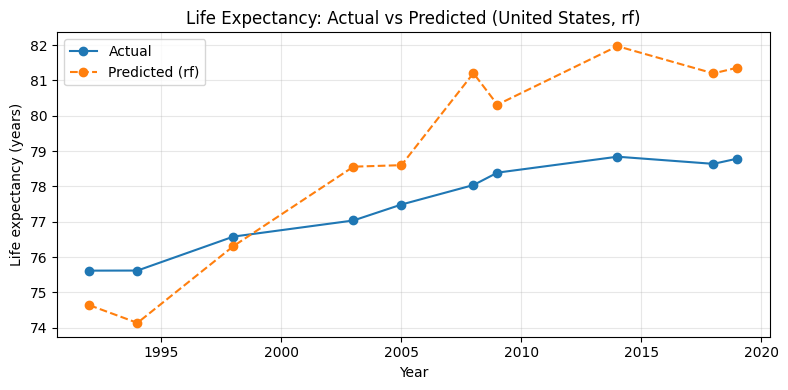

In [22]:
country = "United States"      # change if your dataset uses a different name
model_name = "rf"

us = preds[preds["country_name"] == country].copy()
us = us.sort_values("year")

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(us["year"], us["y_actual"], marker="o", label="Actual")
ax.plot(
    us["year"],
    us[f"y_pred_{model_name}"],
    marker="o",
    linestyle="--",
    label=f"Predicted ({model_name})",
)

ax.set_xlabel("Year")
ax.set_ylabel("Life expectancy (years)")
ax.set_title(f"Life Expectancy: Actual vs Predicted ({country}, {model_name})")
ax.legend()
ax.grid(alpha=0.3)

# Optional: tighten the y-axis a bit if needed, e.g.:
# ax.set_ylim(70, 85)

plt.tight_layout()
out_path = fig_dir / f"{country.lower().replace(' ', '_')}_actual_vs_pred_{model_name}.png"
fig.savefig(out_path, dpi=300)
print("Saved:", out_path)
plt.show()


In [26]:

#| title: "United States: Actual vs Predicted (All Models)"
country = "United States"  # change if your dataset uses a different name

us = preds[preds["country_name"] == country].copy()
us = us.sort_values("year")

us_series_cols = [
    "y_actual",
    "y_pred_linear_regression",
    "y_pred_lgbm",
    "y_pred_rf",
    "y_pred_xgboost",
]

us_wide = us[["year"] + us_series_cols].copy()

us_long = us_wide.melt(
    id_vars="year",
    value_vars=us_series_cols,
    var_name="series",
    value_name="life_expectancy",
)

us_series_labels = {
    "y_actual": "Actual",
    "y_pred_linear_regression": "Linear Regression",
    "y_pred_lgbm": "LightGBM (AutoML)",
    "y_pred_rf": "Random Forest (AutoML)",
    "y_pred_xgboost": "XGBoost (AutoML)",
}

us_long["series"] = us_long["series"].map(us_series_labels)

fig = px.line(
    us_long,
    x="year",
    y="life_expectancy",
    color="series",
    labels={
        "year": "Year",
        "life_expectancy": "Life expectancy (years)",
        "series": "Series",
    },
)
fig.update_layout(legend_title_text="", hovermode="x unified")
fig
